In [189]:
import numpy as np
import pandas as pd
import pandas_profiling # Use pandas_profiling.ProfileReport(df) instead of df.describe()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import (classification_report, fbeta_score, f1_score, recall_score,
                             accuracy_score, precision_score, roc_curve)
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter
from psycopg2 import connect
from haversine import haversine

np.set_printoptions(suppress=True)

In [157]:
df = pd.read_pickle('df.pkl')

# Modeling

In [159]:
df_y = df['is_late']
df_x = df.drop(columns = ['order_delivered_customer_date','order_estimated_delivery_date',
                          'customer_zip_code_prefix','seller_zip_code_prefix',
                          'is_late','order_id','customer_id','product_id','seller_id',
                          'order_purchase_timestamp','order_approved_at','shipping_limit_date',
                          'order_delivered_carrier_date'])
# Dropping all the non-numerical, date and y value from my x value of df
# Also dropping zip code because the model will not interpret that number correctly, and I already have lat/long

df_x.dtypes

price                                     float64
freight_value                             float64
order_item_id                               int64
product_weight_g                          float64
product_length_cm                         float64
product_height_cm                         float64
product_width_cm                          float64
product_vol_cm                            float64
dist_km                                   float64
order_purchased_to_approved                 int64
order_approved_to_delivered_to_carrier      int64
dtype: object

In [160]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y,
                                                    stratify = df_y,  # Include proportional y's in the splits
                                                    random_state = 37)

In [165]:
# StratifiedKFold, if I am interested in redoing my RF without SMOTE, and still want to try GridSearch

random_seed = 37
kf = StratifiedKFold(n_splits=5, random_state=random_seed)
cross_val_f1_score_lst = []
cross_val_accuracy_lst = []
cross_val_recall_lst = []
cross_val_precision_lst = []

for train_index_ls, validation_index_ls in kf.split(x_train, y_train):
    # keeping validation set apart and oversampling in each iteration using smote 
    train, validation = x_train.iloc[train_index_ls], x_train.iloc[validation_index_ls]
    target_train, target_val = y_train.iloc[train_index_ls], y_train.iloc[validation_index_ls]
    sm = SMOTE(random_state=random_seed)
    X_train_res, y_train_res = sm.fit_sample(train, target_train)
    print (X_train_res.shape, y_train_res.shape)
    
    # training the model on oversampled 4 folds of training set
    rf = RandomForestClassifier(n_estimators=5, random_state=random_seed)
    rf.fit(train, target_train)
    
    # testing on 1 fold of validation set
    validation_preds = rf.predict(validation)
    cross_val_recall_lst.append(recall_score(target_val, validation_preds))
    cross_val_accuracy_lst.append(accuracy_score(target_val, validation_preds))
    cross_val_precision_lst.append(precision_score(target_val, validation_preds))
    cross_val_f1_score_lst.append(f1_score(target_val, validation_preds))
    
print ('Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst)))
print ('Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst)))
print ('Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst)))
print ('Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst)))

(119584, 11) (119584,)
(119586, 11) (119586,)
(119586, 11) (119586,)
(119586, 11) (119586,)
(119586, 11) (119586,)
Cross validated accuracy: 0.8915614719783859
Cross validated recall score: 0.17888628714509613
Cross validated precision score: 0.23975394431610947
Cross validated f1_score: 0.2048184152256483


In [166]:
# Scale my features so that everything is in z-scores
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## Oversampling

In [167]:
# SMOTE
x_train_smoted, y_train_smoted = SMOTE(random_state=37).fit_sample(x_train_scaled, y_train)

In [168]:
Counter(y_smoted)

Counter({False: 75866, True: 75866})

In [169]:
# Define a confusion matrix function so that I can graph confusion matrices for each of my models
def confusion_matrix_graphic(prediction, real_y = y_test):
    conf_matrix = metrics.confusion_matrix(real_y, prediction)
    
    plt.figure(dpi=80)
    sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'g',
               xticklabels=['Not late', 'Late'],
               yticklabels=['Not late', 'Late'])

    plt.xlabel('Predicted lateness')
    plt.ylabel('Actual lateness')
    plt.title('Confusion matrix');

## Logistic Regression

In [170]:
# Fitting and predicting with my Logistic Regression
logistic_model = LogisticRegression(random_state = 34, class_weight = 'balanced', n_jobs = -1)

logistic_model.fit(x_train_scaled, y_train)
logit_pred = logistic_model.predict(x_test_scaled)

print(metrics.f1_score(y_test, logit_pred), metrics.recall_score(y_test, logit_pred),
      metrics.precision_score(y_test, logit_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.21221733346976362 0.4917022285443338 0.1353079331941545


**After I run all my models, I can go back in chat and find Han Wei's ensembling that he used**

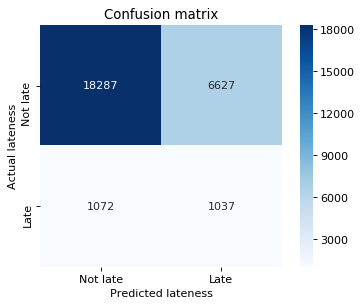

In [171]:
confusion_matrix_graphic(logit_pred)
plt.savefig('logit_confusion.png', bbox_inches = 'tight')

In [172]:
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

       False       0.94      0.73      0.83     24914
        True       0.14      0.49      0.21      2109

   micro avg       0.72      0.72      0.72     27023
   macro avg       0.54      0.61      0.52     27023
weighted avg       0.88      0.72      0.78     27023



In [173]:
list(zip(x_train.columns, logistic_model.coef_[0]))

[('price', 0.0026394998163000285),
 ('freight_value', 0.019627513288729633),
 ('order_item_id', -0.09234996670419095),
 ('product_weight_g', 0.028925117145455346),
 ('product_length_cm', 0.03523185441668526),
 ('product_height_cm', -0.024537080630069843),
 ('product_width_cm', -0.016427247825435087),
 ('product_vol_cm', -0.037726514340754434),
 ('dist_km', 0.2403403905709739),
 ('order_purchased_to_approved', 0.1238355905496773),
 ('order_approved_to_delivered_to_carrier', 0.5464924144297569)]

These results give preliminary evidence that latitude and longitude or both customer and seller are the most important general features of whether a shipment will be late or not.

Surprisingly, weight and volume and dimensions of the package seems to not matter much. What seems to matter a surprising amount is whether there was an additional item in the package (order_item_id). I decided to leave this metric in for possible insights like this - every additional package in an order decreases the likelihood of the package being delivered on time by 2.6%

In [174]:
# This cell calculates the logistic model's coefficient values, and turns it into interpretation
# Need to un-log these coefficients
readjusted_coefs = np.round((logistic_model.coef_[0] / scaler.scale_),8)

sorted(list(zip(abs(np.round(logistic_model.coef_[0], 8)),        # Abs val of the scaled coefficients
                            np.round(logistic_model.coef_[0], 8), # Val of the scaled coefficients
                            readjusted_coefs,                     # Unscaled val of coefficients (for interpretation)
                            x_test.columns)), reverse = True)     # Column labels

# I think all the below coefficients are in log-odds. They still need to be exponentiated and converted to p

[(0.54649241,
  0.54649241,
  0.15402177,
  'order_approved_to_delivered_to_carrier'),
 (0.24034039, 0.24034039, 0.00040803, 'dist_km'),
 (0.12383559, 0.12383559, 0.17782641, 'order_purchased_to_approved'),
 (0.09234997, -0.09234997, -0.12984203, 'order_item_id'),
 (0.03772651, -0.03772651, -1.62e-06, 'product_vol_cm'),
 (0.03523185, 0.03523185, 0.00218558, 'product_length_cm'),
 (0.02892512, 0.02892512, 7.73e-06, 'product_weight_g'),
 (0.02453708, -0.02453708, -0.00182564, 'product_height_cm'),
 (0.01962751, 0.01962751, 0.00125162, 'freight_value'),
 (0.01642725, -0.01642725, -0.00141564, 'product_width_cm'),
 (0.0026395, 0.0026395, 1.438e-05, 'price')]

In [175]:
# Once I solve the shipping distance problem, I need to exponentiate to get the coefficients into log-odds.
# Then once I have log-odds, convert to probability

np.exp(0.039588)

1.0403820484769828

In [176]:
1.00039588**100

1.0403738981754433

In [177]:
df['dist_km'].mean()

# dist_km exponent is 0.00039588

596.4359735606896

**We see below that late deliveries are, on average, ~27% farther away than deliveries that are on time**

In [178]:
# We see that late deliveries are, on average, ~27% farther away than deliveries that are on time
print(df.loc[df['is_late'] == True, 'dist_km'].mean(), df.loc[df['is_late'] == False, 'dist_km'].mean())

print((740.5 - 584.4) / 584.4)

739.8094858099133 584.2976731959608
0.2671115674195757


**I may want to include in my presentation that in my old model, I calculated the change in odds by 1 km on the margin. But I cannot extrapolate that to 1 * 100. Instead I need to recalculate my model based on every 100 km. My log-odd coefficients will be exactly 100x the old coefficients, but when I *exponentiate* that, the amount is sliiiiightly different. This is the change in probability that is compounded from 1 to 100, very similarly to compound interest.**

For example, if I had 12% interest compounded yearly, compared to 1% interest compounded monthly, 1% would be more. But a slightly smaller percentage (0.97% for instance) would be equal. My old 1 km calculation was the old, smaller percentage, and the 100 km calculation was the bigger, 12% calculation

## K-Nearest Neighbors

In [179]:
knn = KNeighborsClassifier(n_jobs = -1)

param_grid = {'n_neighbors': [i for i in range(1,10)]} # Gridsearching through squared values to find ideal KNN
knn_smote_best = GridSearchCV(knn, param_grid, cv = 2, scoring = 'roc_auc')

knn_smote_best.fit(x_train_smoted, y_train_smoted)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [180]:
print(knn_smote_best.best_params_, knn_smote_best.best_score_, knn_smote_best.best_estimator_)

{'n_neighbors': 5} 0.9203201533814052 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')


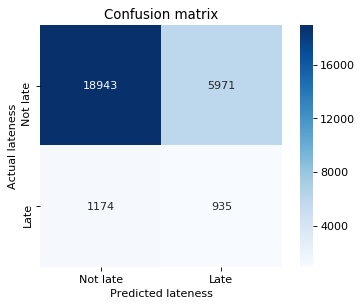

In [181]:
# Run the prediction and confusion matrix function that I defined
knn_smote_pred = knn_smote_best.best_estimator_.predict(x_test_scaled) # Take the best KNN that was found above

confusion_matrix_graphic(knn_smote_pred)
plt.savefig('knn_confusion_matrix.png', bbox_inches = 'tight')

SMOTE is better than ADASYN in my tests. I will delete ADASYN and use SMOTE from now on rather than ADASYN

## Random Forest

In [186]:
# Running the GridSearch to find roughly the best model for my Random Forest
rf = RandomForestClassifier(n_jobs = -1, random_state = 37, class_weight = 'balanced')


param_grid = {'n_estimators' : [i ** 2 for i in range(1,10)],
              'max_depth' : [i ** 2 for i in range (3,8)]}

rf_best = GridSearchCV(rf, param_grid, cv = 2, scoring = 'roc_auc', verbose = 30)

rf_best.fit(x_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits
[CV] max_depth=9, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=9, n_estimators=1, score=0.6263088386882735, total=   1.3s
[CV] max_depth=9, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=9, n_estimators=1, score=0.6166249065026774, total=   0.6s
[CV] max_depth=9, n_estimators=4 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=9, n_estimators=4, score=0.6635246909714974, total=   0.9s
[CV] max_depth=9, n_estimators=4 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=9, n_estimators=4, score=0.6667074598600051, total=   0.3s
[CV] max_depth=9, n_estimators=9 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV]  max_depth=9, n_estimators=9, score=0.6837350489899329, total=   0.4s
[CV] max_depth=9, n_estimators=9 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s


[CV]  max_depth=9, n_estimators=9, score=0.6810188171924789, total=   0.7s
[CV] max_depth=9, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.7s remaining:    0.0s


[CV]  max_depth=9, n_estimators=16, score=0.6881117483248993, total=   0.7s
[CV] max_depth=9, n_estimators=16 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=16, score=0.6873889661149802, total=   0.7s
[CV] max_depth=9, n_estimators=25 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.3s remaining:    0.0s


[CV]  max_depth=9, n_estimators=25, score=0.689978731218028, total=   0.6s
[CV] max_depth=9, n_estimators=25 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=25, score=0.6901706784953958, total=   0.8s
[CV] max_depth=9, n_estimators=36 ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=36, score=0.6915377562954785, total=   1.3s
[CV] max_depth=9, n_estimators=36 ....................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    9.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=36, score=0.6916729745291473, total=   1.9s
[CV] max_depth=9, n_estimators=49 ....................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   11.5s remaining:    0.0s


[CV]  max_depth=9, n_estimators=49, score=0.6924612956814171, total=   1.5s
[CV] max_depth=9, n_estimators=49 ....................................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   13.1s remaining:    0.0s


[CV]  max_depth=9, n_estimators=49, score=0.6933085856506518, total=   1.6s
[CV] max_depth=9, n_estimators=64 ....................................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   14.9s remaining:    0.0s


[CV]  max_depth=9, n_estimators=64, score=0.693679865987205, total=   1.7s
[CV] max_depth=9, n_estimators=64 ....................................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   16.7s remaining:    0.0s


[CV]  max_depth=9, n_estimators=64, score=0.6935224454467861, total=   1.8s
[CV] max_depth=9, n_estimators=81 ....................................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   18.7s remaining:    0.0s


[CV]  max_depth=9, n_estimators=81, score=0.6941244463339054, total=   1.6s
[CV] max_depth=9, n_estimators=81 ....................................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   20.6s remaining:    0.0s


[CV]  max_depth=9, n_estimators=81, score=0.6934995130189208, total=   1.7s
[CV] max_depth=16, n_estimators=1 ....................................
[CV]  max_depth=16, n_estimators=1, score=0.5751488068809211, total=   0.1s
[CV] max_depth=16, n_estimators=1 ....................................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   22.7s remaining:    0.0s


[CV]  max_depth=16, n_estimators=1, score=0.5844452339961846, total=   0.1s
[CV] max_depth=16, n_estimators=4 ....................................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   22.9s remaining:    0.0s


[CV]  max_depth=16, n_estimators=4, score=0.6288774471413013, total=   0.3s
[CV] max_depth=16, n_estimators=4 ....................................


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   23.3s remaining:    0.0s


[CV]  max_depth=16, n_estimators=4, score=0.6326402324518509, total=   0.3s
[CV] max_depth=16, n_estimators=9 ....................................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   23.8s remaining:    0.0s


[CV]  max_depth=16, n_estimators=9, score=0.6577753811078928, total=   0.4s
[CV] max_depth=16, n_estimators=9 ....................................


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   24.3s remaining:    0.0s


[CV]  max_depth=16, n_estimators=9, score=0.6462224502167988, total=   0.5s
[CV] max_depth=16, n_estimators=16 ...................................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   24.9s remaining:    0.0s


[CV]  max_depth=16, n_estimators=16, score=0.6648332632566183, total=   0.6s
[CV] max_depth=16, n_estimators=16 ...................................


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   25.7s remaining:    0.0s


[CV]  max_depth=16, n_estimators=16, score=0.6602360919455461, total=   0.6s
[CV] max_depth=16, n_estimators=25 ...................................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   26.4s remaining:    0.0s


[CV]  max_depth=16, n_estimators=25, score=0.6703187874844035, total=   0.8s
[CV] max_depth=16, n_estimators=25 ...................................


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   27.4s remaining:    0.0s


[CV]  max_depth=16, n_estimators=25, score=0.6674893698069024, total=   0.8s
[CV] max_depth=16, n_estimators=36 ...................................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   28.4s remaining:    0.0s


[CV]  max_depth=16, n_estimators=36, score=0.6747188541816043, total=   1.1s
[CV] max_depth=16, n_estimators=36 ...................................


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   29.6s remaining:    0.0s


[CV]  max_depth=16, n_estimators=36, score=0.6712082839558087, total=   1.1s
[CV] max_depth=16, n_estimators=49 ...................................
[CV]  max_depth=16, n_estimators=49, score=0.6792861417147722, total=   1.5s
[CV] max_depth=16, n_estimators=49 ...................................
[CV]  max_depth=16, n_estimators=49, score=0.6713898658205589, total=   1.5s
[CV] max_depth=16, n_estimators=64 ...................................
[CV]  max_depth=16, n_estimators=64, score=0.6822845218821181, total=   1.9s
[CV] max_depth=16, n_estimators=64 ...................................
[CV]  max_depth=16, n_estimators=64, score=0.6732021196447728, total=   1.8s
[CV] max_depth=16, n_estimators=81 ...................................
[CV]  max_depth=16, n_estimators=81, score=0.6846505243947313, total=   2.5s
[CV] max_depth=16, n_estimators=81 ...................................
[CV]  max_depth=16, n_estimators=81, score=0.6747001742576965, total=   2.3s
[CV] max_depth=25, n_estimators=1 .

[CV]  max_depth=49, n_estimators=49, score=0.6839241566296241, total=   1.9s
[CV] max_depth=49, n_estimators=64 ...................................
[CV]  max_depth=49, n_estimators=64, score=0.6942342298044676, total=   2.7s
[CV] max_depth=49, n_estimators=64 ...................................
[CV]  max_depth=49, n_estimators=64, score=0.6884107045173372, total=   2.7s
[CV] max_depth=49, n_estimators=81 ...................................
[CV]  max_depth=49, n_estimators=81, score=0.6982962182152708, total=   3.0s
[CV] max_depth=49, n_estimators=81 ...................................
[CV]  max_depth=49, n_estimators=81, score=0.6940646368853238, total=   3.1s


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.0min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=37, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 4, 9, 16, 25, 36, 49, 64, 81], 'max_depth': [9, 16, 25, 36, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=30)

In [187]:
print(rf_best.best_params_, rf_best.best_score_, rf_best.best_estimator_)

{'max_depth': 36, 'n_estimators': 81} 0.6981970677185401 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=36, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=81, n_jobs=-1, oob_score=False, random_state=37,
            verbose=0, warm_start=False)


0.4047424366312347


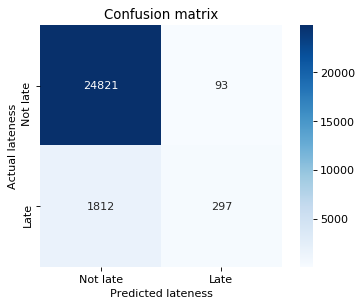

In [188]:
rf_pred = rf_best.best_estimator_.predict(x_test)

confusion_matrix_graphic(rf_pred)
plt.savefig('rf_confusion_matrix.png', bbox_inches = 'tight')

# Valuing Recall : Precision at 66% / 33%
print(fbeta_score(y_test, rf_pred, beta = 0.50))

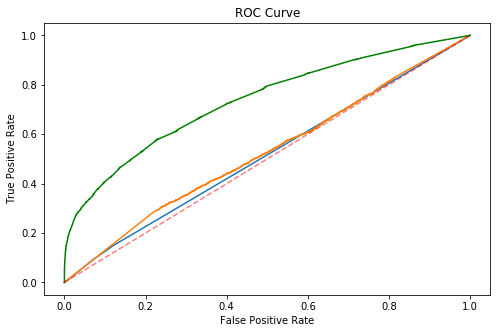

In [234]:
# Graphing a ROC curve for all my plots

# Set the data for my plots
logit_fpr, logit_tpr, _ = roc_curve(y_test, logistic_model.predict_proba(x_test)[:,1])
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_smote_best.predict_proba(x_test)[:,1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_best.predict_proba(x_test)[:,1])


# Plot the ROC
fig, ax = plt.subplots(figsize = (8,5))

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(knn_fpr, knn_tpr)
plt.plot(logit_fpr, logit_tpr)
plt.plot(rf_fpr, rf_tpr, 'g')
plt.plot([0, 1], 'r--', alpha = 0.5) # y = x line

### Question for class tomorrow: Since it is clear above that my Random Forest is much better along all thresholds, how do I get it to prioritize guessing for Recall in the scoring, over Precision? It should have higher Recall than the other, worse methods I used

In [236]:
print('Logistic Regression')
print(f'Recall Score: {recall_score(y_test, logit_pred)}')
print(f'Precision Score: {precision_score(y_test, logit_pred)}')
print(f'FBeta Score: {fbeta_score(y_test, logit_pred, beta = 0.50)}')

print('')
print('K-Nearest Neighbors')
print(f'Recall Score: {recall_score(y_test, knn_smote_pred)}')
print(f'Precision Score: {precision_score(y_test, knn_smote_pred)}')
print(f'FBeta Score: {fbeta_score(y_test, knn_smote_pred, beta = 0.50)}')

print('')
print('Random Forest')
print(f'Recall Score: {recall_score(y_test, rf_pred)}')
print(f'Precision Score: {precision_score(y_test, rf_pred)}')
print(f'FBeta Score: {fbeta_score(y_test, rf_pred, beta = 0.50)}')

Logistic Regression
Recall Score: 0.4917022285443338
Precision Score: 0.1353079331941545
FBeta Score: 0.15824813062719362

K-Nearest Neighbors
Recall Score: 0.44333807491702226
Precision Score: 0.13538951636258326
FBeta Score: 0.1572327044025157

Random Forest
Recall Score: 0.14082503556187767
Precision Score: 0.7615384615384615
FBeta Score: 0.4047424366312347


**Need to choose between using ROC_AUC and F1_Score to score my model when I am making it.**

Conceptually, the ROC_AUC maximizes your model's performance at all levels of threshold (At one corner, it'll classify as 1 when it is 0.01 confident, at the other corner it will only classify upon 0.99 confidence. Everything else in the middle operates on some spectrum of confidence. That spectrum of confidence will result in different False Positive and False Negative rates, and you have to choose where your *actual model* classifies based on your preferences: precision, recall, sensitivity, specificity)

Conceptually, the F1_Score finds the harmonic mean of your optimized precision and recall. To compare it with the ROC_AUC scoring, it'll score your model by picking the threshold that maximizes the harmonic mean between precision and recall, rather than providing the expected results at every threshold (It'll simply pick "the best" threshold, given the weights that you assign to precision and recall, with a default of a 50/50 split)

Jonathan recommends Random Forest for my problem - I'm likely to have late shipments overlapping with not late shipments, without any way to separate them in my dataset.

## Scoring

I'm going to be scoring with weights of 60% for recall and 40% for precision, since I think predicting late deliveries is more important. You can do something like send an email warning that the shipment is going to be late.

# Lessons from this Project

1. Be careful with cross-validation - don't use it if there's no point. If I have enough data, I can make sure that I don't create any oversampling data leakage. Example: I had data leakage in this project because of SMOTE that was used in the cross-validation - giving very different results than what I get on my final test